In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy
from sklearn.datasets import make_classification as Make
from sklearn.model_selection import train_test_split as split

In [8]:
from sklearn.datasets import fetch_lfw_pairs as lfwPairs

In [10]:
E = lfwPairs()

In [11]:
E

{'data': array([[ 73.666664,  71.      ,  82.      , ..., 224.66667 , 228.66667 ,
         231.66667 ],
        [ 85.      , 112.      , 132.66667 , ..., 106.      , 114.333336,
         122.      ],
        [ 37.      ,  35.333332,  34.      , ...,  51.333332,  52.333332,
          52.      ],
        ...,
        [ 73.      ,  94.333336, 121.333336, ...,  64.      ,  71.      ,
          82.      ],
        [119.      , 110.666664, 113.      , ..., 145.33333 , 130.      ,
         102.666664],
        [ 23.333334,  20.333334,  23.666666, ..., 146.66667 , 151.33333 ,
         159.      ]], dtype=float32),
 'pairs': array([[[[ 73.666664,  71.      ,  82.      , ..., 119.      ,
           118.333336, 118.666664],
          [ 70.      ,  70.333336,  86.333336, ..., 117.      ,
           111.666664, 107.      ],
          [ 71.666664,  76.666664,  97.333336, ..., 115.666664,
           114.      , 108.666664],
          ...,
          [154.33333 , 148.33333 , 162.33333 , ..., 155.33333 

In [14]:
E.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [22]:
len(E['target'])

2200

In [7]:
class logRegGD:
    def __init__(self,error, run, pltLength):
        self.weights_original = None # original copy to reference back to
        # generated test/train split
        self.xTrain = None
        self.yTrain = None
        self.xTest = None
        self.yTest = None
        self.weights = None # weights
        self.maxRunTime = run # cut off point for 
        self.initialTime = None # starting time
        self.time = None # time taken for a method run
        self.error = error # allowed error/epsilon
        self.grad = None # current gradient
        self.lamb = None # current step size
        self.gr_list = None # list of values of norms of gradient
        self.norm = None # current norm of gradient 
        self.theta = None # theta value used in Adpative
        self.preds = None # predicted classifications
        self.classi = None # proportion of correct classifications
        # Plots for different methods
        self.vanPlt = None
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = pltLength # maximum value for x axis in plt
    #-------------------------------------------------------------------------------------
    
    def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng) 
        return norm_X 
    
    
    
    def generate(self, samples, test_size): # generates sample data 
        sample_data = Make(n_samples=samples, random_state = 13)
        augmented_data = np.concatenate((np.array([[1]*len(sample_data[0])]).T,\
                                         self.normalise(sample_data[0])), axis =1)
        entire_set = list(sample_data)
        entire_set[0] = augmented_data
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( entire_set[0], entire_set[1], \
                                                                 test_size = test_size, random_state= 13)
        self.weights_original = np.random.rand(len(self.xTrain[0]),1)
    
    # in all methods used, we don't need f for any of them, just gradient(f)
    def cost_func(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        y = np.squeeze(self.yTrain)
        step1 = y * np.log(sig)
        step2 = (1 - y) * np.log(1 - sig) 
        final = -step1 - step2 
        return np.mean(final)
    
    def log_gradient(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = np.squeeze(sig) - np.squeeze(self.yTrain.reshape(self.xTrain.shape[0],-1))
        return np.dot(inner_expr.T, self.xTrain )
    
    def GD(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = np.squeeze(self.weights) - self.lamb * self.log_gradient(self.weights)
    
    def calc_norm(self): # to calculate the norm of a gradient of a weight vector
        self.norm = np.linalg.norm(self.log_gradient(self.weights))
    
    def predict(self, beta, X):
        predP = self.sigmoid(beta, X) # predict classification probability 
        predVal = np.where(predP >= 0.5 , 1 , 0) # allocate most likely classifier
        self.preds = np.squeeze(predVal)
    
    
    #-------------------------------------------------------------------------------------------
    
    def Vanilla(self):
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_original) # make a copy of the weights
        self.gr_list = [] # create a list for recording norms of gradients
        self.lamb = 1/np.max( np.linalg.svd( self.xTrain @ self.xTrain.T )[1] ) # make step size using SVD
        count = 1
        self.calc_norm() # calculate norm of the gradient of the weights
        while self.norm > self.error: # start loop
            self.GD() # Step in steepest negative direction
            self.calc_norm()
            self.gr_list.append(self.norm)
            count += 1
            if time.time() - self.initialTime > self.maxRunTime: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0,  min(len(self.gr_list), self.Max ) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            min1 = np.sqrt(1 + self.theta)*self.lamb
            min2 = ( np.linalg.norm( self.weights - oldW ) ) \
            / ( 2 * np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW)) )
            self.lamb = np.min([min1,min2])
            oldW = deepcopy(self.weights)
            self.GD()
            self.theta = self.lamb/oldLam
            self.calc_norm()
            self.gr_list.append(self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
        self.PrintResults()
    
    def BackTrack(self):
        def normal(X): 
            return np.linalg.norm(X)
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( normal( lam * self.grad ) / \
                     ( normal( self.log_gradient( np.squeeze(self.weights) - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lamb = lam
                
    def LineSearch(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.calc_norm()
        self.grad = self.log_gradient(self.weights)
#         count = 1
        while self.norm > self.error:
            self.BackTrack()
            self.GD()
            self.grad = self.log_gradient(self.weights)
            self.calc_norm()
            self.gr_list.append(self.norm)
#             count +=1
            if time.time() - self.initialTime > self.maxRunTime:
                break
#         print(count)
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.PrintResults()
        
    def Barzilai(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        print('lamda',self.lamb)
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            self.lamb = np.dot( np.squeeze(self.weights - oldW), \
                               self.log_gradient(self.weights) - self.log_gradient(oldW) ) \
                        / np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW) )**2
            print('lamda',self.lamb)
#             oldW = deepcopy(self.weights)
            self.GD()
            self.calc_norm()
            self.gr_list.append( self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'r', self.BazPlt, 'Barzilai {} sec'.format(self.time))
        self.PrintResults()
    
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr_list[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient') # in domain [{}, {}]'.format(0, 600 ) )
        plt.savefig('logregplt.png', dpi=100)
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr_list), ':')
        print('weights vector is:', self.weights)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', self.time)
        print('Final Lambda value: ', self.lamb)
        print('Percentage of points correctly classified: ', self.classi*100, "%")

lamda 0.6062128753454213
lamda [0.2916657  0.28984119 0.29162069 0.29037281 0.2897793  0.29126577
 0.29152677 0.29035243 0.29067227 0.29052574 0.28989245 0.29068282
 0.28983642 0.29159799 0.29096729 0.29160926 0.29074101 0.29056987
 0.29018553 0.2917759  0.28986271]
lamda [0.14033233 0.13850782 0.14028732 0.13903945 0.13844593 0.13993241
 0.14019341 0.13901907 0.13933891 0.13919238 0.13855909 0.13934946
 0.13850306 0.14026462 0.13963393 0.1402759  0.13940765 0.13923651
 0.13885217 0.14044253 0.13852934]
lamda [0.06774895 0.06592444 0.06770394 0.06645607 0.06586255 0.06734902
 0.06761002 0.06643569 0.06675552 0.066609   0.06597571 0.06676607
 0.06591968 0.06768124 0.06705055 0.06769252 0.06682426 0.06665312
 0.06626879 0.06785915 0.06594596]
lamda [0.03293609 0.03111158 0.03289108 0.03164321 0.03104969 0.03253616
 0.03279716 0.03162283 0.03194266 0.03179614 0.03116285 0.03195321
 0.03110682 0.03286838 0.03223768 0.03287966 0.0320114  0.03184026
 0.03145593 0.03304629 0.0311331 ]
lamda [

<ipython-input-7-8919df71e679>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



lamda [0.01078598 0.00702177 0.01069312 0.00811858 0.00689407 0.00996088
 0.01049936 0.00807653 0.0087364  0.0084341  0.00712753 0.00875817
 0.00701193 0.01064629 0.00934507 0.01066955 0.00887822 0.00852514
 0.0077322  0.01101334 0.00706616]
lamda [0.01078247 0.00701817 0.01068961 0.00811501 0.00689047 0.00995734
 0.01049584 0.00807296 0.00873284 0.00843053 0.00712393 0.00875461
 0.00700834 0.01064277 0.00934153 0.01066603 0.00887467 0.00852158
 0.00772861 0.01100983 0.00706257]
lamda [0.010779   0.00701462 0.01068614 0.00811148 0.00688692 0.00995386
 0.01049236 0.00806943 0.00872933 0.00842701 0.00712039 0.0087511
 0.00700479 0.0106393  0.00933803 0.01066256 0.00887116 0.00851806
 0.00772508 0.01100637 0.00705902]
lamda [0.01077557 0.00701111 0.01068271 0.008108   0.00688341 0.00995041
 0.01048893 0.00806595 0.00872586 0.00842354 0.00711688 0.00874763
 0.00700128 0.01063587 0.00933457 0.01065913 0.00886769 0.00851458
 0.00772159 0.01100295 0.00705551]
lamda [0.01077219 0.00700765 0.0

lamda [0.01053669 0.00676834 0.01044373 0.00786636 0.00664051 0.00971068
 0.01024975 0.00782427 0.00848486 0.00818222 0.00687422 0.00850665
 0.0067585  0.01039685 0.0090942  0.01042013 0.00862684 0.00827337
 0.00747955 0.0107643  0.00681279]
lamda [0.01053387 0.00676549 0.01044091 0.00786352 0.00663765 0.00970785
 0.01024693 0.00782142 0.00848202 0.00817938 0.00687137 0.00850381
 0.00675565 0.01039402 0.00909137 0.01041731 0.008624   0.00827053
 0.00747671 0.01076148 0.00680994]
lamda [0.01053104 0.00676263 0.01043808 0.00786067 0.0066348  0.00970502
 0.0102441  0.00781857 0.00847918 0.00817654 0.00686851 0.00850097
 0.00675279 0.01039119 0.00908853 0.01041448 0.00862116 0.00826768
 0.00747385 0.01075865 0.00680708]
lamda [0.01052821 0.00675977 0.01043524 0.00785781 0.00663193 0.00970218
 0.01024126 0.00781572 0.00847633 0.00817369 0.00686565 0.00849812
 0.00674993 0.01038836 0.00908568 0.01041164 0.00861831 0.00826483
 0.007471   0.01075582 0.00680422]
lamda [0.01052537 0.0067569  0.0

lamda [0.01027372 0.00650337 0.01018071 0.00760197 0.00637547 0.00944727
 0.00998662 0.00755986 0.0082208  0.007918   0.00660931 0.0082426
 0.00649352 0.0101338  0.00883046 0.01015709 0.00836285 0.00800919
 0.00721496 0.01050144 0.00654784]
lamda [0.01027106 0.0065007  0.01017805 0.0075993  0.0063728  0.0094446
 0.00998396 0.00755719 0.00821813 0.00791534 0.00660663 0.00823994
 0.00649085 0.01013113 0.0088278  0.01015443 0.00836019 0.00800652
 0.00721229 0.01049878 0.00654517]
lamda [0.0102684  0.00649803 0.01017539 0.00759664 0.00637013 0.00944194
 0.0099813  0.00755452 0.00821547 0.00791267 0.00660397 0.00823727
 0.00648818 0.01012848 0.00882513 0.01015177 0.00835752 0.00800386
 0.00720962 0.01049613 0.0065425 ]
lamda [0.01026574 0.00649536 0.01017273 0.00759397 0.00636746 0.00943928
 0.00997865 0.00755186 0.00821281 0.00791001 0.0066013  0.00823461
 0.00648552 0.01012582 0.00882247 0.01014912 0.00835486 0.0080012
 0.00720696 0.01049347 0.00653983]
lamda [0.01026309 0.0064927  0.0101

lamda [0.01004745 0.00627652 0.00995443 0.0073753  0.0061486  0.00922087
 0.00976032 0.00733317 0.00799422 0.00769138 0.00638248 0.00801603
 0.00626668 0.00990751 0.00860397 0.00993081 0.00813629 0.00778258
 0.00698822 0.01027521 0.006321  ]
lamda [0.01004495 0.00627402 0.00995193 0.00737279 0.0061461  0.00921837
 0.00975781 0.00733067 0.00799172 0.00768887 0.00637997 0.00801352
 0.00626417 0.00990501 0.00860147 0.00992831 0.00813379 0.00778007
 0.00698572 0.01027271 0.0063185 ]
lamda [0.01004245 0.00627152 0.00994943 0.00737029 0.0061436  0.00921587
 0.00975531 0.00732817 0.00798921 0.00768637 0.00637747 0.00801102
 0.00626167 0.00990251 0.00859897 0.00992581 0.00813129 0.00777757
 0.00698322 0.01027021 0.006316  ]
lamda [0.01003995 0.00626902 0.00994693 0.00736779 0.00614109 0.00921337
 0.00975281 0.00732567 0.00798671 0.00768387 0.00637497 0.00800852
 0.00625917 0.00990001 0.00859647 0.00992331 0.00812879 0.00777507
 0.00698071 0.01026771 0.00631349]
lamda [0.01003745 0.00626651 0.0

 0.00676998 0.01005712 0.00610273]
lamda [0.00982694 0.00605585 0.00973392 0.00715467 0.00592792 0.00900033
 0.0095398  0.00711255 0.00777362 0.00747076 0.00616181 0.00779543
 0.006046   0.009687   0.0083834  0.0097103  0.0079157  0.00756197
 0.00676758 0.01005472 0.00610033]
lamda [0.00982454 0.00605345 0.00973151 0.00715227 0.00592552 0.00899793
 0.00953739 0.00711014 0.00777122 0.00746836 0.00615941 0.00779303
 0.0060436  0.00968459 0.008381   0.0097079  0.0079133  0.00755957
 0.00676518 0.01005231 0.00609793]
lamda [0.00982214 0.00605105 0.00972911 0.00714987 0.00592312 0.00899553
 0.00953499 0.00710774 0.00776882 0.00746596 0.00615701 0.00779063
 0.0060412  0.00968219 0.0083786  0.0097055  0.0079109  0.00755717
 0.00676278 0.01004991 0.00609553]
lamda [0.00981974 0.00604865 0.00972672 0.00714747 0.00592072 0.00899313
 0.00953259 0.00710534 0.00776642 0.00746356 0.00615461 0.00778823
 0.0060388  0.0096798  0.0083762  0.0097031  0.0079085  0.00755477
 0.00676038 0.01004752 0.0060931

lamda [0.00962187 0.00585072 0.00952884 0.00694956 0.00572279 0.00879524
 0.00933471 0.00690743 0.00756852 0.00726566 0.00595668 0.00759032
 0.00584087 0.00948191 0.00817831 0.00950522 0.0077106  0.00735686
 0.00656246 0.00984964 0.0058952 ]
lamda [0.00961955 0.00584841 0.00952652 0.00694724 0.00572048 0.00879293
 0.0093324  0.00690512 0.0075662  0.00726334 0.00595437 0.00758801
 0.00583856 0.0094796  0.00817599 0.0095029  0.00770828 0.00735455
 0.00656015 0.00984733 0.00589289]
lamda [0.00961724 0.0058461  0.00952421 0.00694493 0.00571817 0.00879062
 0.00933009 0.00690281 0.00756389 0.00726103 0.00595206 0.0075857
 0.00583625 0.00947729 0.00817368 0.00950059 0.00770597 0.00735224
 0.00655784 0.00984502 0.00589058]
lamda [0.00961493 0.00584379 0.0095219  0.00694262 0.00571586 0.0087883
 0.00932778 0.0069005  0.00756158 0.00725872 0.00594975 0.00758339
 0.00583394 0.00947498 0.00817137 0.00949828 0.00770366 0.00734993
 0.00655552 0.0098427  0.00588827]
lamda [0.00961262 0.00584148 0.009

lamda [0.00941985 0.00564869 0.00932682 0.00674753 0.00552076 0.00859322
 0.0091327  0.0067054  0.00736649 0.00706363 0.00575465 0.0073883
 0.00563884 0.0092799  0.00797628 0.0093032  0.00750857 0.00715484
 0.00636043 0.00964763 0.00569317]
lamda [0.00941762 0.00564646 0.00932459 0.0067453  0.00551853 0.008591
 0.00913047 0.00670318 0.00736426 0.0070614  0.00575242 0.00738607
 0.00563661 0.00927767 0.00797406 0.00930098 0.00750635 0.00715261
 0.0063582  0.0096454  0.00569094]
lamda [0.0094154  0.00564424 0.00932237 0.00674308 0.00551631 0.00858877
 0.00912825 0.00670095 0.00736204 0.00705918 0.0057502  0.00738385
 0.00563439 0.00927545 0.00797183 0.00929875 0.00750412 0.00715038
 0.00635598 0.00964318 0.00568872]
lamda [0.00941317 0.00564201 0.00932014 0.00674085 0.00551408 0.00858655
 0.00912602 0.00669873 0.00735981 0.00705695 0.00574797 0.00738162
 0.00563216 0.00927322 0.00796961 0.00929653 0.0075019  0.00714816
 0.00635375 0.00964095 0.00568649]
lamda [0.00941095 0.00563979 0.0093

lamda [0.00923187 0.00546069 0.00913884 0.00655954 0.00533276 0.00840524
 0.00894471 0.00651741 0.0071785  0.00687564 0.00556665 0.00720031
 0.00545084 0.00909192 0.00778829 0.00911522 0.00732058 0.00696684
 0.00617244 0.00945965 0.00550517]
lamda [0.00922972 0.00545855 0.00913669 0.00655739 0.00533062 0.00840309
 0.00894257 0.00651526 0.00717635 0.00687349 0.00556451 0.00719816
 0.0054487  0.00908977 0.00778615 0.00911307 0.00731844 0.0069647
 0.00617029 0.0094575  0.00550303]
lamda [0.00922758 0.0054564  0.00913455 0.00655525 0.00532847 0.00840095
 0.00894042 0.00651312 0.00717421 0.00687135 0.00556236 0.00719602
 0.00544655 0.00908763 0.00778401 0.00911093 0.00731629 0.00696256
 0.00616815 0.00945536 0.00550088]
lamda [0.00922544 0.00545426 0.00913241 0.0065531  0.00532633 0.0083988
 0.00893828 0.00651098 0.00717207 0.0068692  0.00556022 0.00719387
 0.00544441 0.00908548 0.00778186 0.00910879 0.00731415 0.00696041
 0.006166   0.00945321 0.00549874]
lamda [0.00922329 0.00545212 0.009

lamda [0.00904454 0.00527335 0.00895151 0.0063722  0.00514542 0.00821791
 0.00875739 0.00633008 0.00699117 0.0066883  0.00537931 0.00701298
 0.0052635  0.00890459 0.00760097 0.0089279  0.00713325 0.00677951
 0.0059851  0.00927232 0.00531784]
lamda [0.00904248 0.00527129 0.00894945 0.00637014 0.00514336 0.00821585
 0.00875533 0.00632801 0.0069891  0.00668624 0.00537725 0.00701091
 0.00526144 0.00890253 0.0075989  0.00892583 0.00713119 0.00677745
 0.00598304 0.00927026 0.00531577]
lamda [0.00904042 0.00526923 0.00894739 0.00636807 0.0051413  0.00821378
 0.00875326 0.00632595 0.00698704 0.00668418 0.00537519 0.00700885
 0.00525938 0.00890047 0.00759684 0.00892377 0.00712912 0.00677539
 0.00598097 0.0092682  0.00531371]
lamda [0.00903836 0.00526716 0.00894532 0.00636601 0.00513923 0.00821172
 0.0087512  0.00632389 0.00698498 0.00668211 0.00537312 0.00700679
 0.00525731 0.0088984  0.00759478 0.00892171 0.00712706 0.00677332
 0.00597891 0.00926613 0.00531165]
lamda [0.00903629 0.0052651  0.0

lamda [0.00886034 0.00508913 0.00876731 0.00618798 0.0049612  0.0080337
 0.00857318 0.00614586 0.00680695 0.00650409 0.00519509 0.00682876
 0.00507928 0.00872039 0.00741675 0.00874369 0.00694904 0.0065953
 0.00580088 0.00908812 0.00513361]
lamda [0.00885836 0.00508715 0.00876532 0.006186   0.00495922 0.00803172
 0.0085712  0.00614388 0.00680497 0.0065021  0.00519311 0.00682678
 0.0050773  0.0087184  0.00741477 0.00874171 0.00694705 0.00659331
 0.0057989  0.00908613 0.00513163]
lamda [0.00885637 0.00508516 0.00876334 0.00618402 0.00495723 0.00802973
 0.00856921 0.00614189 0.00680299 0.00650012 0.00519113 0.00682479
 0.00507532 0.00871642 0.00741279 0.00873972 0.00694507 0.00659133
 0.00579692 0.00908415 0.00512965]
lamda [0.00885439 0.00508318 0.00876136 0.00618203 0.00495525 0.00802775
 0.00856723 0.00613991 0.006801   0.00649814 0.00518914 0.00682281
 0.00507333 0.00871444 0.0074108  0.00873774 0.00694309 0.00658935
 0.00579493 0.00908217 0.00512766]
lamda [0.00885241 0.0050812  0.008

lamda [0.00866616 0.00489493 0.00857313 0.00599379 0.004767   0.00783952
 0.008379   0.00595167 0.00661276 0.0063099  0.00500089 0.00663457
 0.00488508 0.00852621 0.00722257 0.00854951 0.00675485 0.00640111
 0.00560669 0.00889394 0.00493941]
lamda [0.00866426 0.00489303 0.00857123 0.00599189 0.0047651  0.00783762
 0.0083771  0.00594977 0.00661086 0.006308   0.00499899 0.00663267
 0.00488318 0.00852431 0.00722067 0.00854761 0.00675295 0.00639921
 0.00560479 0.00889204 0.00493752]
lamda [0.00866236 0.00489114 0.00856933 0.00598999 0.0047632  0.00783572
 0.0083752  0.00594787 0.00660897 0.0063061  0.0049971  0.00663077
 0.00488129 0.00852241 0.00721877 0.00854571 0.00675105 0.00639731
 0.00560289 0.00889014 0.00493562]
lamda [0.00866046 0.00488924 0.00856743 0.0059881  0.00476131 0.00783382
 0.00837331 0.00594597 0.00660707 0.0063042  0.0049952  0.00662888
 0.00487939 0.00852051 0.00721687 0.00854381 0.00674915 0.00639541
 0.00560099 0.00888824 0.00493372]
lamda [0.00865857 0.00488734 0.0

 0.00543357 0.00872084 0.00476629]
lamda [0.00849123 0.00471999 0.0083982  0.00581885 0.00459205 0.00766458
 0.00820407 0.00577672 0.00643783 0.00613496 0.00482595 0.00645963
 0.00471014 0.00835128 0.00704763 0.00837458 0.00657991 0.00622617
 0.00543174 0.00871901 0.00476447]
lamda [0.00848941 0.00471816 0.00839638 0.00581703 0.00459023 0.00766276
 0.00820225 0.0057749  0.006436   0.00613313 0.00482412 0.00645781
 0.00470831 0.00834946 0.00704581 0.00837276 0.00657809 0.00622434
 0.00542992 0.00871719 0.00476264]
lamda [0.00848759 0.00471634 0.00839456 0.00581521 0.00458841 0.00766094
 0.00820043 0.00577308 0.00643418 0.00613131 0.0048223  0.00645599
 0.00470649 0.00834763 0.00704399 0.00837094 0.00657627 0.00622252
 0.0054281  0.00871537 0.00476082]
lamda [0.00848577 0.00471452 0.00839274 0.00581338 0.00458659 0.00765912
 0.00819861 0.00577126 0.00643236 0.00612949 0.00482048 0.00645417
 0.00470467 0.00834581 0.00704217 0.00836912 0.00657445 0.0062207
 0.00542628 0.00871355 0.004759  

 0.00527092 0.00855821 0.00460364]
lamda [0.00832868 0.00455741 0.00823564 0.00565628 0.00442948 0.00750202
 0.00804151 0.00561415 0.00627526 0.00597239 0.00466337 0.00629707
 0.00454756 0.00818872 0.00688507 0.00821202 0.00641734 0.0060636
 0.00526917 0.00855646 0.00460189]
lamda [0.00832693 0.00455566 0.00823389 0.00565453 0.00442772 0.00750027
 0.00803976 0.0056124  0.00627351 0.00597064 0.00466162 0.00629532
 0.00454581 0.00818697 0.00688332 0.00821027 0.00641559 0.00606185
 0.00526742 0.00855471 0.00460014]
lamda [0.00832518 0.00455391 0.00823214 0.00565278 0.00442598 0.00749852
 0.00803801 0.00561065 0.00627176 0.00596889 0.00465987 0.00629357
 0.00454406 0.00818522 0.00688157 0.00820852 0.00641384 0.0060601
 0.00526567 0.00855296 0.00459839]
lamda [0.00832343 0.00455216 0.0082304  0.00565103 0.00442423 0.00749678
 0.00803627 0.0056089  0.00627001 0.00596714 0.00465812 0.00629182
 0.00454231 0.00818347 0.00687982 0.00820678 0.0064121  0.00605835
 0.00526392 0.00855121 0.00459664]

lamda [0.00817092 0.00439963 0.00807789 0.00549851 0.0042717  0.00734426
 0.00788376 0.00545638 0.00611749 0.00581462 0.00450559 0.0061393
 0.00438978 0.00803096 0.0067273  0.00805427 0.00625958 0.00590583
 0.0051114  0.0083987  0.00444411]
lamda [0.00816924 0.00439795 0.00807621 0.00549683 0.00427002 0.00734258
 0.00788208 0.0054547  0.00611581 0.00581294 0.00450391 0.00613762
 0.0043881  0.00802929 0.00672562 0.00805259 0.0062579  0.00590415
 0.00510972 0.00839703 0.00444243]
lamda [0.00816756 0.00439627 0.00807453 0.00549515 0.00426834 0.00734091
 0.0078804  0.00545302 0.00611413 0.00581126 0.00450224 0.00613594
 0.00438642 0.00802761 0.00672395 0.00805091 0.00625622 0.00590247
 0.00510804 0.00839535 0.00444075]
lamda [0.00816589 0.00439459 0.00807285 0.00549347 0.00426666 0.00733923
 0.00787872 0.00545134 0.00611245 0.00580958 0.00450056 0.00613426
 0.00438475 0.00802593 0.00672227 0.00804923 0.00625454 0.00590079
 0.00510636 0.00839367 0.00443908]
lamda [0.00816421 0.00439292 0.00

lamda [0.008018   0.00424668 0.00792496 0.00534557 0.00411875 0.00719134
 0.00773083 0.00530344 0.00596456 0.00566168 0.00435265 0.00598636
 0.00423684 0.00787804 0.00657437 0.00790135 0.00610664 0.00575289
 0.00495846 0.00824578 0.00429117]
lamda [0.00801639 0.00424508 0.00792336 0.00534396 0.00411714 0.00718973
 0.00772922 0.00530183 0.00596295 0.00566007 0.00435104 0.00598475
 0.00423523 0.00787643 0.00657276 0.00789974 0.00610503 0.00575128
 0.00495685 0.00824418 0.00428956]
lamda [0.00801478 0.00424347 0.00792175 0.00534235 0.00411553 0.00718812
 0.00772762 0.00530022 0.00596134 0.00565846 0.00434943 0.00598315
 0.00423362 0.00787482 0.00657116 0.00789813 0.00610343 0.00574967
 0.00495524 0.00824257 0.00428795]
lamda [0.00801317 0.00424186 0.00792014 0.00534074 0.00411392 0.00718651
 0.00772601 0.00529862 0.00595973 0.00565686 0.00434782 0.00598154
 0.00423201 0.00787322 0.00656955 0.00789652 0.00610182 0.00574807
 0.00495363 0.00824096 0.00428634]
lamda [0.00801157 0.00424025 0.0

lamda [0.0078715  0.00410016 0.00777846 0.00519905 0.00397222 0.00704483
 0.00758433 0.00515692 0.00581804 0.00551517 0.00420612 0.00583985
 0.00409031 0.00773154 0.00642786 0.00775485 0.00596013 0.00560638
 0.00481194 0.00809929 0.00414464]
lamda [0.00786996 0.00409862 0.00777692 0.00519751 0.00397068 0.00704329
 0.00758279 0.00515538 0.0058165  0.00551362 0.00420458 0.00583831
 0.00408877 0.00773    0.00642632 0.0077533  0.00595859 0.00560484
 0.00481039 0.00809775 0.0041431 ]
lamda [0.00786842 0.00409708 0.00777538 0.00519597 0.00396914 0.00704175
 0.00758125 0.00515384 0.00581496 0.00551208 0.00420304 0.00583677
 0.00408723 0.00772846 0.00642478 0.00775176 0.00595705 0.0056033
 0.00480885 0.00809621 0.00414156]
lamda [0.00786688 0.00409554 0.00777384 0.00519443 0.0039676  0.00704021
 0.00757971 0.0051523  0.00581342 0.00551054 0.0042015  0.00583523
 0.00408569 0.00772692 0.00642324 0.00775022 0.00595551 0.00560176
 0.00480731 0.00809467 0.00414002]
lamda [0.00786534 0.004094   0.00

 0.00467317 0.00796054 0.00400587]
lamda [0.00773128 0.00395991 0.00763825 0.00505881 0.00383198 0.00690461
 0.00744411 0.00501669 0.00567781 0.00537493 0.00406588 0.00569962
 0.00395006 0.00759132 0.00628764 0.00761463 0.0058199  0.00546614
 0.0046717  0.00795907 0.0040044 ]
lamda [0.00772981 0.00395844 0.00763677 0.00505734 0.0038305  0.00690313
 0.00744264 0.00501521 0.00567633 0.00537346 0.00406441 0.00569814
 0.00394859 0.00758985 0.00628616 0.00761315 0.00581843 0.00546467
 0.00467022 0.0079576  0.00400292]
lamda [0.00772833 0.00395697 0.0076353  0.00505587 0.00382903 0.00690166
 0.00744116 0.00501374 0.00567486 0.00537198 0.00406293 0.00569667
 0.00394712 0.00758838 0.00628469 0.00761168 0.00581695 0.0054632
 0.00466875 0.00795612 0.00400145]
lamda [0.00772686 0.00395549 0.00763383 0.00505439 0.00382756 0.00690019
 0.00743969 0.00501227 0.00567339 0.00537051 0.00406146 0.0056952
 0.00394564 0.0075869  0.00628321 0.00761021 0.00581548 0.00546172
 0.00466727 0.00795465 0.00399998]

 0.00453902 0.00782642 0.00387172]
lamda [0.00759722 0.00382583 0.00750419 0.00492473 0.00369789 0.00677054
 0.00731005 0.00488261 0.00554373 0.00524085 0.00393179 0.00556554
 0.00381598 0.00745726 0.00615356 0.00748057 0.00568583 0.00533207
 0.00453761 0.00782501 0.00387031]
lamda [0.00759581 0.00382442 0.00750278 0.00492333 0.00369648 0.00676913
 0.00730864 0.0048812  0.00554233 0.00523944 0.00393038 0.00556413
 0.00381457 0.00745585 0.00615216 0.00747916 0.00568442 0.00533066
 0.0045362  0.0078236  0.0038689 ]
lamda [0.00759441 0.00382301 0.00750137 0.00492192 0.00369507 0.00676773
 0.00730723 0.00487979 0.00554092 0.00523804 0.00392898 0.00556273
 0.00381316 0.00745445 0.00615075 0.00747775 0.00568301 0.00532925
 0.0045348  0.0078222  0.00386749]
lamda [0.007593   0.0038216  0.00749996 0.00492051 0.00369367 0.00676632
 0.00730583 0.00487838 0.00553951 0.00523663 0.00392757 0.00556132
 0.00381175 0.00745304 0.00614934 0.00747634 0.0056816  0.00532784
 0.00453339 0.00782079 0.0038660

 0.00440958 0.00769701 0.00374228]
lamda [0.00746787 0.00369645 0.00737484 0.00479536 0.00356851 0.00664119
 0.0071807  0.00475324 0.00541437 0.00511149 0.00380241 0.00543618
 0.0036866  0.00732791 0.0060242  0.00735122 0.00555646 0.0052027
 0.00440824 0.00769566 0.00374093]
lamda [0.00746653 0.0036951  0.00737349 0.00479402 0.00356717 0.00663984
 0.00717936 0.00475189 0.00541303 0.00511014 0.00380107 0.00543483
 0.00368525 0.00732657 0.00602286 0.00734987 0.00555512 0.00520136
 0.0044069  0.00769432 0.00373959]
lamda [0.00746519 0.00369376 0.00737215 0.00479268 0.00356582 0.0066385
 0.00717801 0.00475055 0.00541168 0.0051088  0.00379973 0.00543349
 0.00368391 0.00732523 0.00602152 0.00734853 0.00555378 0.00520001
 0.00440555 0.00769298 0.00373825]
lamda [0.00746384 0.00369242 0.00737081 0.00479134 0.00356448 0.00663716
 0.00717667 0.00474921 0.00541034 0.00510746 0.00379839 0.00543215
 0.00368257 0.00732388 0.00602018 0.00734719 0.00555243 0.00519867
 0.00440421 0.00769164 0.0037369 ]

lamda [0.00734589 0.00357444 0.00725286 0.00467336 0.0034465  0.0065192
 0.00705872 0.00463123 0.00529237 0.00498949 0.00368041 0.00531418
 0.00356459 0.00720593 0.00590221 0.00722924 0.00543447 0.0050807
 0.00428624 0.00757369 0.00361892]
lamda [0.00734461 0.00357316 0.00725158 0.00467208 0.00344522 0.00651792
 0.00705744 0.00462995 0.00529109 0.00498821 0.00367913 0.0053129
 0.00356331 0.00720465 0.00590093 0.00722796 0.00543319 0.00507942
 0.00428496 0.00757241 0.00361764]
lamda [0.00734334 0.00357188 0.0072503  0.0046708  0.00344394 0.00651664
 0.00705616 0.00462868 0.00528981 0.00498693 0.00367785 0.00531162
 0.00356203 0.00720337 0.00589966 0.00722668 0.00543191 0.00507814
 0.00428368 0.00757113 0.00361636]
lamda [0.00734206 0.0035706  0.00724902 0.00466953 0.00344266 0.00651536
 0.00705488 0.0046274  0.00528854 0.00498565 0.00367657 0.00531035
 0.00356075 0.0072021  0.00589838 0.0072254  0.00543063 0.00507687
 0.0042824  0.00756985 0.00361508]
lamda [0.00734078 0.00356932 0.0072

lamda [0.00723102 0.00345953 0.00713798 0.00455846 0.00333159 0.00640432
 0.00694384 0.00451633 0.00517748 0.00487459 0.00356549 0.00519929
 0.00344968 0.00709105 0.00578732 0.00711436 0.00531957 0.0049658
 0.00417133 0.00745881 0.00350401]
lamda [0.0072298  0.00345831 0.00713676 0.00455724 0.00333037 0.0064031
 0.00694262 0.00451511 0.00517626 0.00487337 0.00356428 0.00519807
 0.00344846 0.00708984 0.00578611 0.00711314 0.00531835 0.00496459
 0.00417011 0.00745759 0.00350279]
lamda [0.00722858 0.00345709 0.00713554 0.00455603 0.00332915 0.00640188
 0.0069414  0.0045139  0.00517504 0.00487215 0.00356306 0.00519685
 0.00344724 0.00708862 0.00578489 0.00711192 0.00531714 0.00496337
 0.0041689  0.00745638 0.00350158]
lamda [0.00722737 0.00345588 0.00713433 0.00455481 0.00332793 0.00640066
 0.00694019 0.00451268 0.00517383 0.00487094 0.00356184 0.00519564
 0.00344603 0.0070874  0.00578367 0.00711071 0.00531592 0.00496215
 0.00416768 0.00745516 0.00350036]
lamda [0.00722615 0.00345466 0.007

lamda [0.00710914 0.00333762 0.0070161  0.00443656 0.00320967 0.00628244
 0.00682196 0.00439443 0.00505558 0.00475269 0.00344359 0.00507739
 0.00332777 0.00696918 0.00566544 0.00699248 0.00519768 0.00484391
 0.00404943 0.00733694 0.0033821 ]
lamda [0.007108   0.00333647 0.00701496 0.00443541 0.00320852 0.00628129
 0.00682081 0.00439328 0.00505444 0.00475154 0.00344244 0.00507624
 0.00332662 0.00696803 0.00566429 0.00699134 0.00519653 0.00484276
 0.00404828 0.00733579 0.00338095]
lamda [0.00710685 0.00333532 0.00701381 0.00443426 0.00320738 0.00628014
 0.00681967 0.00439214 0.00505329 0.0047504  0.00344129 0.0050751
 0.00332547 0.00696688 0.00566314 0.00699019 0.00519538 0.00484161
 0.00404713 0.00733465 0.0033798 ]
lamda [0.0071057  0.00333417 0.00701266 0.00443312 0.00320623 0.00627899
 0.00681852 0.00439099 0.00505214 0.00474925 0.00344014 0.00507395
 0.00332432 0.00696574 0.00566199 0.00698904 0.00519424 0.00484046
 0.00404598 0.0073335  0.00337866]
lamda [0.00710455 0.00333302 0.00

 0.00394105 0.0072286  0.00327372]
lamda [0.00699972 0.00322815 0.00690668 0.00432711 0.00310021 0.006173
 0.00671253 0.00428498 0.00494614 0.00464324 0.00333412 0.00496795
 0.0032183  0.00685975 0.00555599 0.00688306 0.00508823 0.00473446
 0.00393997 0.00722752 0.00327264]
lamda [0.00699863 0.00322706 0.00690559 0.00432602 0.00309912 0.00617192
 0.00671145 0.00428389 0.00494505 0.00464216 0.00333304 0.00496686
 0.00321721 0.00685867 0.00555491 0.00688197 0.00508715 0.00473337
 0.00393888 0.00722643 0.00327155]
lamda [0.00699755 0.00322598 0.00690451 0.00432494 0.00309804 0.00617083
 0.00671036 0.00428281 0.00494397 0.00464107 0.00333195 0.00496578
 0.00321613 0.00685758 0.00555383 0.00688089 0.00508607 0.00473229
 0.0039378  0.00722535 0.00327047]
lamda [0.00699647 0.0032249  0.00690343 0.00432386 0.00309695 0.00616975
 0.00670928 0.00428173 0.00494288 0.00463999 0.00333087 0.00496469
 0.00321505 0.0068565  0.00555274 0.00687981 0.00508498 0.00473121
 0.00393672 0.00722427 0.00326938]

lamda [0.00689861 0.003127   0.00680557 0.00422597 0.00299906 0.00607189
 0.00661143 0.00418384 0.00484501 0.00454211 0.00323298 0.00486682
 0.00311715 0.00675865 0.00545487 0.00678195 0.00498711 0.00463333
 0.00383883 0.00712642 0.00317149]
lamda [0.00689759 0.00312598 0.00680455 0.00422495 0.00299804 0.00607086
 0.0066104  0.00418282 0.00484399 0.00454109 0.00323195 0.0048658
 0.00311613 0.00675762 0.00545385 0.00678093 0.00498609 0.00463231
 0.00383781 0.00712539 0.00317047]
lamda [0.00689657 0.00312496 0.00680353 0.00422393 0.00299702 0.00606984
 0.00660938 0.0041818  0.00484297 0.00454007 0.00323093 0.00486478
 0.00311511 0.0067566  0.00545283 0.00677991 0.00498507 0.00463129
 0.00383679 0.00712437 0.00316945]
lamda [0.00689555 0.00312394 0.00680251 0.00422291 0.002996   0.00606882
 0.00660836 0.00418078 0.00484195 0.00453905 0.00322991 0.00486376
 0.00311409 0.00675558 0.00545181 0.00677889 0.00498404 0.00463027
 0.00383577 0.00712335 0.00316843]
lamda [0.00689453 0.00312292 0.00

lamda [0.00681599 0.00304435 0.00672295 0.00414333 0.0029164  0.00598926
 0.0065288  0.0041012  0.00476237 0.00445947 0.00315032 0.00478418
 0.0030345  0.00667602 0.00537224 0.00669933 0.00490447 0.00455069
 0.00375618 0.0070438  0.00308883]
lamda [0.00681502 0.00304338 0.00672198 0.00414236 0.00291543 0.00598829
 0.00652783 0.00410023 0.0047614  0.0044585  0.00314935 0.00478321
 0.00303353 0.00667505 0.00537127 0.00669836 0.0049035  0.00454972
 0.00375521 0.00704283 0.00308786]
lamda [0.00681405 0.00304241 0.00672101 0.00414139 0.00291446 0.00598732
 0.00652686 0.00409926 0.00476043 0.00445753 0.00314838 0.00478224
 0.00303256 0.00667409 0.0053703  0.00669739 0.00490253 0.00454875
 0.00375424 0.00704186 0.0030869 ]
lamda [0.00681309 0.00304144 0.00672005 0.00414042 0.0029135  0.00598635
 0.0065259  0.00409829 0.00475946 0.00445656 0.00314741 0.00478127
 0.00303159 0.00667312 0.00536933 0.00669642 0.00490156 0.00454778
 0.00375327 0.00704089 0.00308593]
lamda [0.00681212 0.00304047 0.0

lamda [0.0067277  0.00295601 0.00663466 0.00405501 0.00282807 0.00590096
 0.00644051 0.00401287 0.00467405 0.00437115 0.00306199 0.00469586
 0.00294616 0.00658773 0.00528393 0.00661104 0.00481616 0.00446237
 0.00366785 0.00695551 0.0030005 ]
lamda [0.00672679 0.0029551  0.00663375 0.0040541  0.00282716 0.00590005
 0.0064396  0.00401197 0.00467314 0.00437024 0.00306108 0.00469496
 0.00294525 0.00658682 0.00528302 0.00661013 0.00481525 0.00446146
 0.00366694 0.0069546  0.00299959]
lamda [0.00672588 0.00295419 0.00663284 0.00405319 0.00282625 0.00589914
 0.00643869 0.00401106 0.00467224 0.00436933 0.00306017 0.00469405
 0.00294434 0.00658591 0.00528211 0.00660922 0.00481434 0.00446055
 0.00366604 0.00695369 0.00299868]
lamda [0.00672497 0.00295329 0.00663193 0.00405228 0.00282534 0.00589823
 0.00643778 0.00401015 0.00467133 0.00436842 0.00305926 0.00469314
 0.00294343 0.006585   0.00528121 0.00660831 0.00481343 0.00445964
 0.00366513 0.00695278 0.00299777]
lamda [0.00672407 0.00295238 0.0

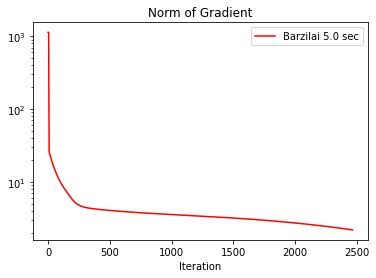

In [8]:
G = logRegGD(1e-6 , 5, 2*10**4)
G.generate(1000, 0.1)
# G.Vanilla()
# G.Adaptive()
# G.LineSearch()
G.Barzilai()
G.PrintPlots()

Ten iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20849 :
weights vector is: [-6.22561587  0.04256582  9.3584898   0.02379012 -0.56410442 -0.50221444
  0.42311936 -0.86459184  0.17156576 -0.45067373 -0.9853813  -0.52479257
 -0.61945765 -1.23687149 -0.66016969 -0.2618121   0.58199479 16.91960443
 -0.79719631 -8.32186719 -0.83504877]
Gradient Norm is: 1.201921437378414
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %


<ipython-input-28-b32c6f05f8df>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2513 :
weights vector is: [-1.00769724e+01  4.35965682e-01  1.04657405e+01  9.94898938e-01
 -2.39016493e+00  4.70355909e-03  1.24378783e+00 -7.05270171e-01
  1.25543730e+00 -6.51602221e-03 -8.13552832e-01 -1.13072955e-01
 -3.20040356e-01 -7.22216859e-01 -2.53862457e-01  5.21729351e-01
  1.05646480e+00  1.93159441e+01 -4.15309422e-01 -1.08195936e+01
 -5.91846752e-01]
Gradient Norm is: 0.09948917724965174
Time taken: 2.33
Final Lambda value:  0.003829004126344555
Percentage of points correctly classified:  94.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 71 :
weights vector is: [-1.63357227 -0.18330003  5.04015068 -0.64268662  0.36337362 -0.79475847
 -0.13416527 -0.62414367 -0.50361621 -0.21580918 -0.67321743 -0.6836795
 -0.31957141 -0.76776731 -0.55584344 -0.24999526 -0.07060998  8.64051399
 -0.78202137 -3.56444536 -0.46269836]
Grad

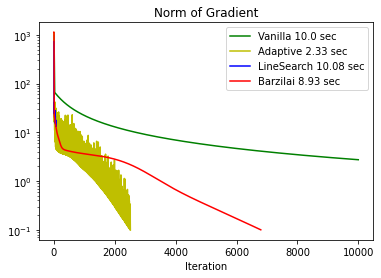

epsilon = 0.01 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 21145 :
weights vector is: [-6.86781397  0.04453002  9.61700316  0.03242958  0.05576266 -0.49544676
  0.42854437 -0.86367898  0.18669701 -0.45042795 -0.98612751 -0.52081191
 -0.6179171  -1.23355278 -0.65652057 -0.25612397  0.59053562 16.81303356
 -0.79476623 -7.90360312 -0.83375715]
Gradient Norm is: 1.1834766548405895
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1909 :
weights vector is: [-10.25896054   0.3922101   10.60485834   0.88832915  -1.54805028
  -0.04567192   1.15214891  -0.7265436    1.13983555  -0.06173409
  -0.83445475  -0.15508728  -0.3609643   -0.78991194  -0.30291842
   0.42545936   1.00820314  

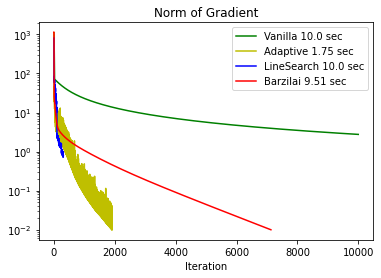

epsilon = 0.001 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 21114 :
weights vector is: [-6.66215285  0.04749806  8.87802016  0.03627401 -0.36231047 -0.49626223
  0.43321032 -0.86073553  0.18578245 -0.44586771 -0.98118435 -0.51786349
 -0.61601173 -1.22661752 -0.65339876 -0.25145839  0.59166432 17.36667599
 -0.79195971 -7.73801243 -0.83094289]
Gradient Norm is: 1.1819512528333176
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4069 :
weights vector is: [-10.08181606   0.39656176   9.87870857   0.89889136  -1.97839301
  -0.04071854   1.1612291   -0.72419688   1.1513386   -0.05611807
  -0.83211252  -0.15084612  -0.35682418  -0.78294947  -0.29783469
   0.43509305   1.01311804 

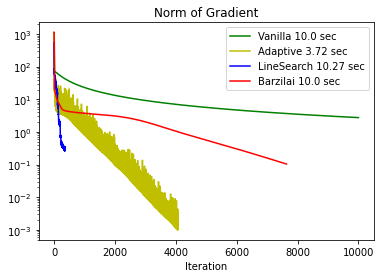

epsilon = 0.0001 , 
allowed time = 10  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20901 :
weights vector is: [-6.56830962  0.04256401  9.03138164  0.01970673 -0.30922215 -0.5052553
  0.42180065 -0.86506317  0.16468967 -0.4527263  -0.98565411 -0.52654146
 -0.62246054 -1.24253825 -0.66215586 -0.2672524   0.57983941 17.20597871
 -0.79920703 -7.80892239 -0.83672988]
Gradient Norm is: 1.206436553558166
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4346 :
weights vector is: [-10.0499648    0.39612525  10.04255828   0.89782981  -1.9566678
  -0.04121979   1.16031735  -0.72442221   1.15018284  -0.056675
  -0.83233632  -0.1512697   -0.35723509  -0.78363628  -0.29833556
   0.43413081   1.01262904  19.

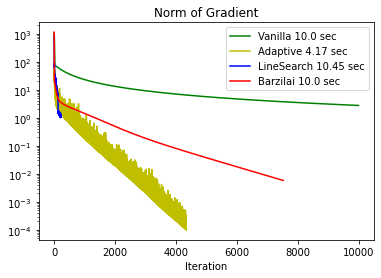

In [29]:
for i in range(1,5):
    G = logRegGD(10**(-i) , 10, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 10, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

Five iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 15  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39418 :
weights vector is: [-15.47866434  -0.08327419  12.97120425   0.18517643  -0.65840735
   0.97928547  -0.40586421   0.25878919   1.31619643   0.21993512
   0.14584561  -0.04435746  -0.07392422  -0.77997806   0.5077678
  -1.01706889   2.7130574    0.18079599   2.958318    -2.23937093
  13.28268529]
Gradient Norm is: 0.9296334575431787
Time taken: 15.0
Final Lambda value:  0.00017585084236340878
Percentage of points correctly classified:  87.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3505 :
weights vector is: [-20.63800541   0.24780854  15.38810447   0.69493623  -0.51344031
   1.57229538   0.19281497   0.65084395   1.56522192   0.65659198
   0.21544402   0.22851002   0.44551385  -0.59818002   1.04751945
  -1.01359338   2.91531929   0.70981089   2.37422534  -2.04234437
  15.70766247]
Gradient Norm is: 0.09973175434652759
Time taken: 2.7
Final Lambda value:  0.0031225504167791207
Percentage of points correctly classified:  87.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 557 :
weights vector is: [-17.01622391   0.02027234  13.66107056   0.34883767  -0.60881913
   1.1724238   -0.21112981   0.37622408   1.39325503   0.352607
   0.16810085   0.04274225   0.07928378  -0.72083267   0.67236323
  -1.01442849   2.75636369   0.34349015   2.76653393  -2.16178969
  13.97492745]
Gradient Norm is: 0.668788705492041
Time taken

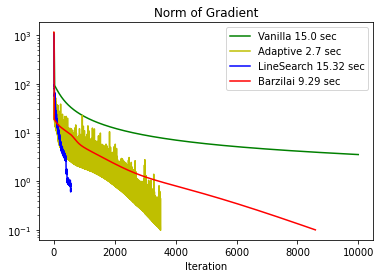

epsilon = 0.01 , 
allowed time = 30  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 61701 :
weights vector is: [-3.72151625  0.41808347  0.68540925 -0.76494779 17.30983889 -0.02552924
 -0.63796743  0.26682967 -0.67220449  3.96821422 -0.38613223 -5.30778612
  1.16500245  0.42280368 -0.58489062 -0.4925009  -2.0459384   0.20403246
 -0.63865925 -2.88892682 -0.22048274]
Gradient Norm is: 0.009999767993436335
Time taken: 23.08
Final Lambda value:  0.000199079619862159
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2270 :
weights vector is: [-3.74572642  0.42556239  0.69480804 -0.76147031 17.33146063 -0.02252939
 -0.63463123  0.2752152  -0.67092134  3.96649998 -0.38317208 -5.32287251
  1.16788934  0.42833027 -0.58242432 -0.49142934 -2.0443705   0.21181303
 -0.63

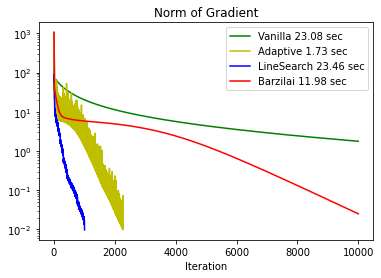

epsilon = 0.001 , 
allowed time = 45  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 116996 :
weights vector is: [-9.32750889 -0.07784469  0.49576113  0.57856713  5.86055605 -0.74868675
  1.01929957 -0.38811366  0.57790274  0.16705814  5.26545192  1.2266124
  0.97443626 -0.58516387  5.81079693 -0.26388519 -0.87834483  0.95537392
 -1.02518938 -0.7905964  -0.17437301]
Gradient Norm is: 0.0009999567392222767
Time taken: 43.18
Final Lambda value:  0.00017688540345140588
Percentage of points correctly classified:  84.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4208 :
weights vector is: [-9.33221964 -0.07744727  0.49619533  0.57908352  5.8610132  -0.74839205
  1.01981973 -0.38771105  0.57853327  0.16747672  5.26602116  1.22726802
  0.97503303 -0.58478754  5.81110566 -0.2635889  -0.87788317  0.95589206
 -

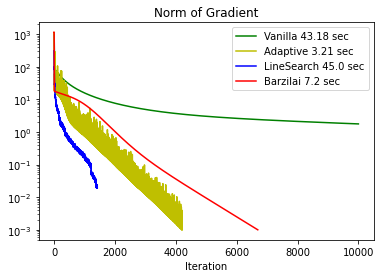

epsilon = 0.0001 , 
allowed time = 60  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 113154 :
weights vector is: [ -2.03577745  -0.63811338   5.66947805   1.53360247   0.15746489
   0.52214458   0.2894102   -0.86361159  12.0094521   -0.70743476
   0.16924969  -0.31046751   1.36075577  -1.29659145  -0.70678508
  -0.03683104  -1.08811658 -11.75982634   1.19277956  -0.60973381
   0.3320069 ]
Gradient Norm is: 9.999270320336075e-05
Time taken: 41.75
Final Lambda value:  0.00016986641522217684
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3266 :
weights vector is: [ -2.03595116  -0.63807326   5.66949434   1.53363857   0.15751598
   0.5221949    0.28947445  -0.86358957  12.00953814  -0.70741899
   0.16927847  -0.31045539   1.36082416  -1.29672122  -0.70675517

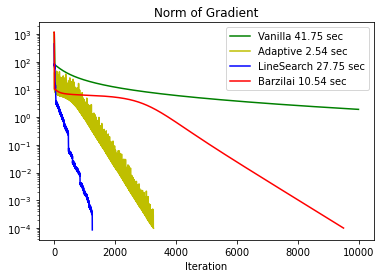

epsilon = 1e-05 , 
allowed time = 75  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 200828 :
weights vector is: [  3.30032061 -12.73329831  -0.57589108  -0.62710692  -0.60685032
   0.79963442  -4.13305835  17.86072879  -2.09391071  -0.94568908
   0.69586548  -2.64681429   3.8090133   -0.13231121   0.66407593
   0.8064575    0.06929732   1.09047775  -2.29166489  -0.44463568
   0.93860003]
Gradient Norm is: 0.00036778078765789855
Time taken: 75.0
Final Lambda value:  0.00018863026250739672
Percentage of points correctly classified:  92.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4595 :
weights vector is: [  3.30100646 -12.73379859  -0.57601846  -0.62730864  -0.60705525
   0.79959992  -4.13309251  17.86197959  -2.09420151  -0.9458525
   0.69577456  -2.64708912   3.80942616  -0.13239685   0.66411821
 

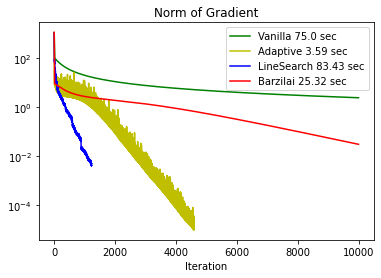

In [18]:
for i in range(1,6):
    G = logRegGD(10**(-i) , 15*i, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 15*i, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

One iterations, $ \epsilon < 10^{-1}$, 15 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39190 :
weights vector is: [-11.3701796   16.9184937    0.49099119  -0.59191859   2.51388772
   0.50259873   0.34189022   0.3330157   -0.29125516  -0.71322257
   0.64256127  -1.08144477  -0.44533297   0.22530737   6.72544529
  -0.28854479  -3.11007145  -1.9577218    0.37949478  -0.25289226
  -0.7846777 ]
Gradient Norm is: 0.5832665136716818
Time taken: 15.0
Final Lambda value:  0.00017156150707073328
Percentage of points correctly classified:  86.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1860 :
weights vector is: [-13.32902009  18.25364561   0.79221631  -0.44615027   2.18926056
   0.76970979   0.50453468   0.5659366   -0.14491914  -0.58928196
   0.87160198  -1.06791629  -0.31552764   0.43623467   7.28472097
  -0.20114224  -3.58384677  -1.90198509   0.56857185  -0.0497695
  -0.73553277]
Gradient Norm is: 0.09963918239142554
Time taken: 1.42
Final Lambda value:  0.002056616475093286
Percentage of points correctly classified:  86.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 430 :
weights vector is: [-8.12214827e+00  1.47978662e+01  5.67075210e-04 -8.63437436e-01
  3.10301816e+00  2.43516317e-02  6.32384518e-02 -4.81690234e-02
 -5.52086872e-01 -9.31389730e-01  2.63827014e-01 -1.13406192e+00
 -6.65889332e-01 -1.36880697e-01  5.82868587e+00 -4.54561706e-01
 -2.33238442e+00 -2.05335751e+00  5.27177612e-02 -5.91781945e-01

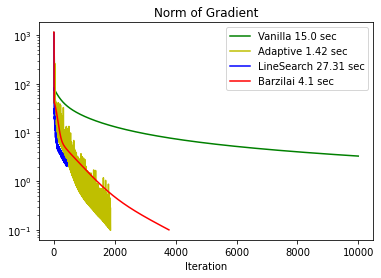

In [8]:
G = logRegGD(1e-1 , 15, 10**4)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-3}$, 30 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 20366 :
weights vector is: [-6.76952939e+00  3.90163583e-02  9.34910100e+00  1.08632115e-02
  2.36395929e-02 -5.10944853e-01  4.13825234e-01 -8.61001266e-01
  1.55877619e-01 -4.52439346e-01 -9.82432142e-01 -5.31017188e-01
 -6.19753580e-01 -1.23323968e+00 -6.59941686e-01 -2.66928128e-01
  5.78389637e-01  1.68883238e+01 -7.99353487e-01 -7.72812981e+00
 -8.31466024e-01]
Gradient Norm is: 1.2366263232510022
Time taken: 10.0
Final Lambda value:  0.00018669671871523696
Percentage of points correctly classified:  94.0 %


<ipython-input-28-b32c6f05f8df>:29: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4351 :
weights vector is: [-10.29315274   0.39656205  10.39551631   0.89889208  -1.63623798
  -0.04071821   1.16122971  -0.72419673   1.15133937  -0.05611769
  -0.83211238  -0.15084584  -0.35682391  -0.78294901  -0.29783436
   0.43509369   1.01311837  19.13776864  -0.45606225 -10.02967775
  -0.62469085]
Gradient Norm is: 0.0009998566058553675
Time taken: 4.1
Final Lambda value:  0.0039031643829538095
Percentage of points correctly classified:  94.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 449 :
weights vector is: [-9.66206113  0.32169724 10.44092309  0.72477743 -1.2651124  -0.10484488
  1.01175699 -0.80853515  0.96021594 -0.19123845 -0.91670027 -0.21917946
 -0.46262205 -0.97049409 -0.42642388  0.2325034   0.92952823 19.13100059
 -0.55638282 -9.73001837 -0.75127684]
Gradient Norm is: 0.2957105507608952
Time taken: 10.2
Final Lamb

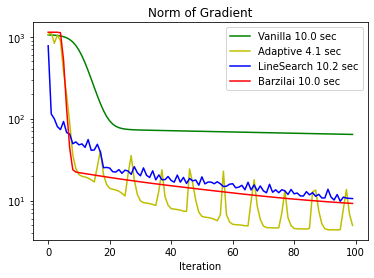

In [30]:
G = logRegGD(1e-3 , 10, 100)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-6}$, 60 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 164040 :
weights vector is: [-1.59926765e+01 -9.97314385e-01 -5.98851396e-01  1.44763622e+00
 -8.12062011e-02  6.73154351e-01 -5.47256403e-01  1.66570914e+01
  1.12132665e+00  4.71680790e+00 -9.90048943e-02 -1.20520221e+01
  2.99490621e-01  9.81301405e-02  8.81485654e-02 -2.19672620e-01
 -4.70798029e-01  2.65720530e+00  4.36148790e-01  2.55759699e+01
  2.15136486e-02]
Gradient Norm is: 0.05504849255050246
Time taken: 60.0
Final Lambda value:  0.00018973892080890458
Percentage of points correctly classified:  90.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 12561 :
weights vector is: [-16.26932173  -1.01187947  -0.61032088   1.48558102  -0.06084642
   0.69534958  -0.54969767  16.86681822   1.15656571   4.75795893
  -0.08098138 -12.2509196    0.31773433   0.11586477   0.09731235
  -0.20213984  -0.46803852   2.71701533   0.45521177  25.92930351
   0.03579833]
Gradient Norm is: 9.992183014771204e-07
Time taken: 9.62
Final Lambda value:  0.005300012835674103
Percentage of points correctly classified:  90.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 2323 :
weights vector is: [-16.17735896  -1.00694844  -0.60643096   1.47294491  -0.06759888
   0.68799235  -0.5488333   16.79680403   1.14483469   4.74405596
  -0.08694626 -12.18469738   0.31172129   0.10999016   0.09431242
  -0.20794432  -0.46890947   2.69719113   0.44887926  25.81140164
   0.03108517]
Gradient Norm is: 0.02000869137557162
Ti

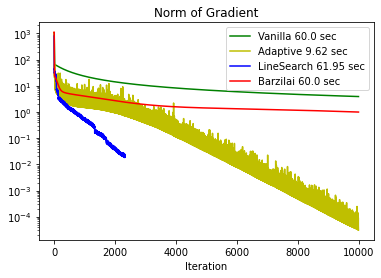

In [7]:
G = logRegGD(1e-6 , 60, 10**4)
G.generate(1000,0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()